<h1>Stutter recognition</h1>

In [1]:
#imports
import os
import cv2
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
DATASET_PATH = './digits'  # Folder with fluent/ and stutter/
SAMPLE_RATE = 16000
N_MFCC = 12
MAX_LEN = 160  # max frame length for MFCC

<h2>Reading values from the audio files</h2>

In [3]:
def read_txt_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    # Filter only lines that contain numbers
    numeric_lines = []
    for line in lines:
        try:
            float(line.strip())  # Try converting
            numeric_lines.append(line.strip())
        except ValueError:
            continue  # Skip headers or non-numeric lines

    return np.array([float(x) for x in numeric_lines])


<h2>Applying gaussian filter</h2>

In [4]:
def apply_gaussian_filter(y):
    return gaussian_filter1d(y, sigma=1)

<h2>MFCC Extraction</h2>

In [16]:
def extract_mfcc(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC,n_fft=320,hop_length=80)
    return mfcc

In [6]:
def process_file(filepath):
    y = read_txt_file(filepath)
    y = librosa.util.fix_length(y, size=SAMPLE_RATE)  # trim or pad
    y_gaussian = apply_gaussian_filter(y)
    mfcc = extract_mfcc(y_gaussian, SAMPLE_RATE)
    return mfcc

<h3>Dataset structure</h3>

digits
 - fluent(10 recordings of each digit(0-9))
 - stutter
   - prolong(5 recordings of each digit)
   - repeat (5 recordings of each digit)

<h2>Dataset loading</h2>

In [7]:
def load_dataset():
    X = []
    y = []
    filenames = []
    labels = {'fluent': 0, 'prolong': 1, 'repeat': 2}

    # Fluent
    fluent_path = os.path.join(DATASET_PATH, 'fluent')
    for file in os.listdir(fluent_path):
        if file.endswith('.txt'):
            mfcc = process_file(os.path.join(fluent_path, file))
            X.append(mfcc)
            y.append(labels['fluent'])
            filenames.append(file)    

    # Stutter - prolong
    prolong_path = os.path.join(DATASET_PATH, 'stutter', 'prolong')
    for file in os.listdir(prolong_path):
        if file.endswith('.txt'):
            mfcc = process_file(os.path.join(prolong_path, file))
            X.append(mfcc)
            y.append(labels['prolong'])
            filenames.append(file)

    # Stutter - repeations
    repeations_path = os.path.join(DATASET_PATH, 'stutter', 'repeat')
    for file in os.listdir(repeations_path):
        if file.endswith('.txt'):
            mfcc = process_file(os.path.join(repeations_path, file))
            X.append(mfcc)
            y.append(labels['repeat'])
            filenames.append(file)

    return np.array(X), np.array(y), np.array(filenames)

In [8]:
X, y, filenames = load_dataset()

<h2>Spilting the data for train and testing</h2>

In [9]:
X_padded = np.array([np.pad(x, ((0,0), (0, MAX_LEN - x.shape[1])), mode='constant')[:, :MAX_LEN] for x in X])
X_padded = X_padded[..., np.newaxis] 
y_cat = to_categorical(y, num_classes=3)
X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(X_padded, y_cat, filenames, test_size=0.2, random_state=42)

<h2>Building the CNN model</h2>

In [10]:
# --- Build CNN Model ---
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=X_padded.shape[1:]),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 158, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 5, 79, 32)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 5, 79, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 77, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 38, 64)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 1, 38, 64)         0

<h2>Training the model</h2>

In [12]:
# --- Train ---
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
5/5 [==============================] - 5s 241ms/step - loss: 17.9266 - accuracy: 0.4500 - val_loss: 1.0036 - val_accuracy: 0.6250
Epoch 2/20
5/5 [==============================] - 0s 98ms/step - loss: 10.2373 - accuracy: 0.4250 - val_loss: 1.2152 - val_accuracy: 0.6000
Epoch 3/20
5/5 [==============================] - 0s 98ms/step - loss: 5.5491 - accuracy: 0.5938 - val_loss: 1.8198 - val_accuracy: 0.7000
Epoch 4/20
5/5 [==============================] - 0s 103ms/step - loss: 3.2245 - accuracy: 0.6062 - val_loss: 0.6743 - val_accuracy: 0.7000
Epoch 5/20
5/5 [==============================] - 0s 98ms/step - loss: 2.0316 - accuracy: 0.5750 - val_loss: 0.6746 - val_accuracy: 0.6250
Epoch 6/20
5/5 [==============================] - 0s 99ms/step - loss: 1.3029 - accuracy: 0.6750 - val_loss: 0.4532 - val_accuracy: 0.8750
Epoch 7/20
5/5 [==============================] - 0s 97ms/step - loss: 0.9947 - accuracy: 0.6875 - val_loss: 0.3873 - val_accuracy: 0.9250
Epoch 8/20
5/5 [=======

<h2>Predictions for each test file </h2>

In [13]:
# Predict
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Label mapping
label_map = {0: 'fluent', 1: 'prolong', 2: 'repeations'}

# Print comparison
print(f"{'Filename':<30} {'Actual':<12} {'Predicted':<12}")
print("="*60)
for i in range(len(filenames_test)):
    actual = label_map[y_true_labels[i]]
    predicted = label_map[y_pred_labels[i]]
    print(f"{filenames_test[i]:<30} {actual:<12} {predicted:<12}")

2/2 [==============================] - 0s 10ms/step
Filename                       Actual       Predicted   
210101063_E_9_5.txt            fluent       fluent      
210101063_E_1_5.txt            fluent       fluent      
210101063_E_3_1.txt            fluent       fluent      
210101063_repeat_1_4.txt       repeations   repeations  
210101063_prolong_5_4.txt      prolong      prolong     
210101063_prolong_3_1.txt      prolong      prolong     
210101063_E_6_9.txt            fluent       fluent      
210101063_repeat_4_1.txt       repeations   repeations  
210101063_repeat_4_5.txt       repeations   repeations  
210101063_E_4_5.txt            fluent       fluent      
210101063_E_6_6.txt            fluent       fluent      
210101063_repeat_6_3.txt       repeations   repeations  
210101063_repeat_3_1.txt       repeations   repeations  
210101063_E_7_8.txt            fluent       fluent      
210101063_repeat_7_2.txt       repeations   repeations  
210101063_repeat_5_3.txt       repea

<h2>Classification Report</h2>

In [14]:
label_names = ['fluent', 'prolong', 'repeations']
print("\nCNN Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_names))


CNN Classification Report:
              precision    recall  f1-score   support

      fluent       1.00      0.95      0.98        21
     prolong       1.00      1.00      1.00         9
  repeations       0.91      1.00      0.95        10

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.98        40
weighted avg       0.98      0.97      0.98        40



<h2>Confussion Matrix</h2>

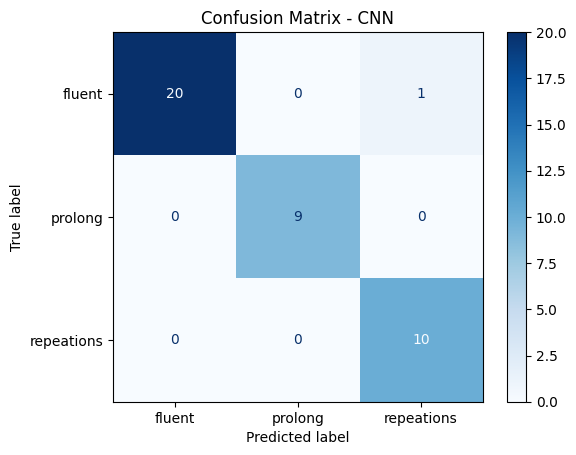

In [15]:
labels = ['fluent', 'prolong', 'repeations']
cm = confusion_matrix(y_true_labels, y_pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - CNN')
plt.show()